In [1]:
import torch
import torchvision
import torch.nn as nn
from d2l import torch as d2l

## Image Augmentation

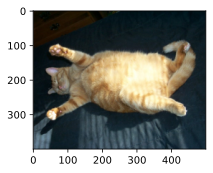

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

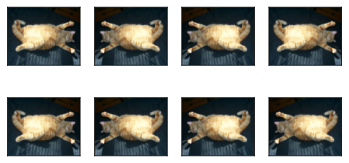

In [4]:
# Flipping and cropping

apply(img, torchvision.transforms.RandomHorizontalFlip())

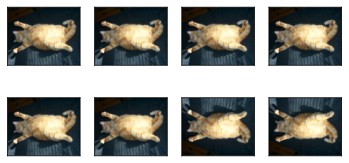

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

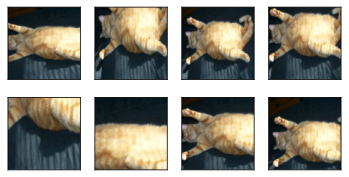

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

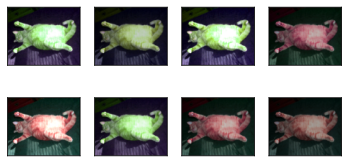

In [7]:
# Changing colors
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.05, saturation=0.1, hue=0.2)
apply(img, color_aug)

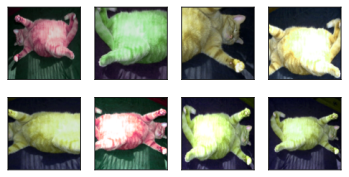

In [8]:
# Combining multiple image augmentation methods

augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),color_aug, shape_aug])
apply(img, augs)

Files already downloaded and verified


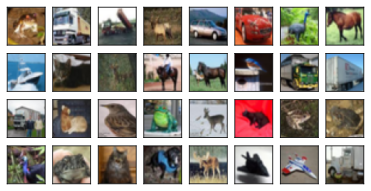

In [9]:
# Training with image augmentation

all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [10]:
# Apply image augmentation and ToTensor
train_augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                             torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [11]:
# Define function to read the image and apply image augmentation

def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='../data', train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                            shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [12]:
# Multi GPU training 

def train_batch_cifar(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else: 
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_cifar(net, train_iter, test_iter, loss, trainer, num_epochs,
                devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = net.to(devices[0])
    # net = nn.DataParallel(net, device_ids=devices)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_cifar(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

The function gets all available GPUs, since I have only one, it only uses one GPU. So, I had to change the devices to specify the available gpu

In [13]:
import torch

batch_size, devices, net = 256,torch.device("cuda:0"), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001, devices=[torch.device("cuda:0")]):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_cifar(net, train_iter, test_iter, loss, trainer, 10, devices)

/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 0.230, train acc 0.920, test acc 0.837
730.9 examples/sec on [device(type='cuda', index=0)]


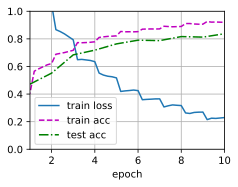

In [14]:
train_with_data_aug(train_augs, test_augs, net, lr=0.001)

# Fine-Tuning ResNet Model pretrained on ImageNet dataset for hot dog recognition

In [16]:
import os

d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

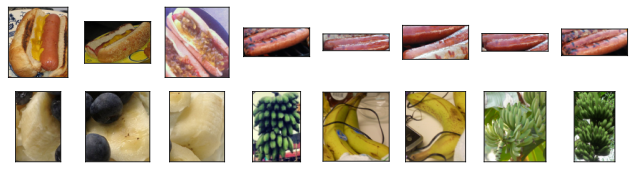

In [17]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [18]:
# Standardize each chanel specifying the means and SD

normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [19]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/drishya/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [20]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [21]:
# Initializing the parameters before the output layer of resnet

finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [31]:

def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.205, train acc 0.922, test acc 0.935
219.0 examples/sec on [device(type='cuda', index=0)]


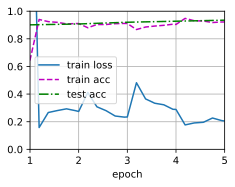

In [32]:
train_fine_tuning(finetune_net, 5e-5)

In [33]:
print(net.fc.parameters)

<bound method Module.parameters of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=512, out_features=10, bias=True)
)>
